In [43]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils import resample
# For modeling
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from tqdm import tqdm
from matplotlib.colors import ListedColormap
#sns.set_palette('viridis')
pd.options.mode.chained_assignment = None  # Supress warning, default='warn'

# Read Data
In this section we read the data in after the preprocessing from the preprocessing notebook

In [2]:
df = pd.read_pickle('../data/preprocessed/accepted_df_preprocessed.pkl')
print(f"Shape of df: {df.shape}")
df.head(5)

Shape of df: (1345310, 101)


,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_length,home_ownership,...,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,hardship_flag,disbursement_method,debt_settlement_flag
0,3600.0,3600.0,3600.0,36,13.99,123.03,C,C4,10.0,MORTGAGE,...,0.0,0.0,0.0,178050.0,7746.0,2400.0,13734.0,N,Cash,N
1,24700.0,24700.0,24700.0,36,11.99,820.28,C,C1,10.0,MORTGAGE,...,7.7,0.0,0.0,314017.0,39475.0,79300.0,24667.0,N,Cash,N
2,20000.0,20000.0,20000.0,60,10.78,432.66,B,B4,10.0,MORTGAGE,...,50.0,0.0,0.0,218418.0,18696.0,6200.0,14877.0,N,Cash,N
4,10400.0,10400.0,10400.0,60,22.45,289.91,F,F1,3.0,MORTGAGE,...,60.0,0.0,0.0,439570.0,95768.0,20300.0,88097.0,N,Cash,N
5,11950.0,11950.0,11950.0,36,13.44,405.18,C,C3,4.0,RENT,...,100.0,0.0,0.0,16900.0,12798.0,9400.0,4000.0,N,Cash,N


# Model Preprocessing: Encode Features from categorical to numerical

In [3]:
# Preview categorical data
print(df.dtypes.value_counts())
# Get categorical columns names
cat_columns = df.select_dtypes(include=['object']).columns.tolist()
# change format
for col in cat_columns:
    df[col] = df[col].astype('category')

float64    87
object     13
int64       1
dtype: int64


In [4]:
# Testing: One-Hot-Encoding
df_ohe = pd.get_dummies(data=df, columns=cat_columns, drop_first=True)
# check
df_ohe.dtypes.value_counts()

uint8      115
float64     87
int64        1
dtype: int64

In [5]:
# Binary Encoding
import category_encoders as ce
encoder = ce.BinaryEncoder(cols=cat_columns)
df_binary = encoder.fit_transform(df)
# check
df_binary.dtypes.value_counts()

float64    87
int64      37
dtype: int64

In [7]:
# Convert all values to float
df_binary = df_binary.astype(float)
df_ohe = df_ohe.astype(float)

# Create Balanced Data Set via Downsampling

0.0    1076751
1.0     268559
Name: loan_status, dtype: int64
(1345310, 124)


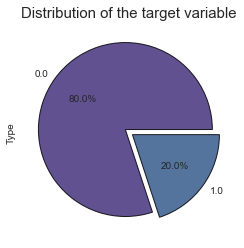

In [32]:
print(df_binary.loan_status.value_counts())
print(df_binary.shape)

plt.title("Distribution of the target variable", size=15)
df_binary.groupby('loan_status').size().plot(kind='pie', y = "loan_status",
                                             label = "Type", autopct='%1.1f%%',
                                             wedgeprops = {"edgecolor": "black", "alpha": 0.85},
                                             explode = [0.05, 0.05])
plt.show()

In [27]:
# Take only fraction of the data
# TODO: DELETED THIS LATER, ONLY FOR LOCAL RUNNING
df_binary_sample = df_binary.sample(frac = 0.05)
print(df_binary_sample.shape)
print(df_binary_sample.loan_status.value_counts())

(67266, 124)
0.0    53865
1.0    13401
Name: loan_status, dtype: int64


0.0    17421
1.0    13401
Name: loan_status, dtype: int64


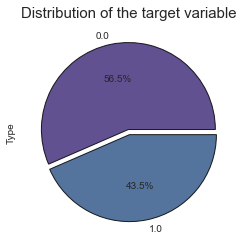

In [33]:
# Downsampling
loan_status_0 = df_binary_sample[df_binary_sample["loan_status"] == 0.0]
loan_status_1  = df_binary_sample[df_binary_sample["loan_status"] == 1.0]

loan_status_0_downsample = resample(loan_status_0,
             replace=True,
             n_samples=round(1.3*len(loan_status_1)),
             random_state=42)

df_binary_downsampled = pd.concat([loan_status_0_downsample, loan_status_1])

print(df_binary_downsampled["loan_status"].value_counts())
# Plot settings
plt.title("Distribution of the target variable", size=15)
df_binary_downsampled.groupby('loan_status').size().plot(kind='pie', y = "loan_status",
                                             label = "Type", autopct='%1.1f%%',
                                             wedgeprops = {"edgecolor": "black", "alpha": 0.85},
                                             explode = [0.03, 0.03])
plt.show()

In [34]:
# Fill NaNs with Median
df_binary_downsampled = df_binary_downsampled.fillna(df_binary_downsampled.median())
# Preview
df_binary_downsampled.head(5)

,loan_amnt,funded_amnt,funded_amnt_inv,term_0,term_1,int_rate,installment,grade_0,grade_1,grade_2,...,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,hardship_flag_0,disbursement_method_0,disbursement_method_1,debt_settlement_flag_0,debt_settlement_flag_1
2000340,15000.0,15000.0,15000.0,1.0,0.0,12.79,339.69,0.0,0.0,1.0,...,0.0,57280.0,18358.0,43900.0,9880.0,1.0,0.0,1.0,0.0,1.0
376271,19000.0,19000.0,19000.0,0.0,1.0,7.89,594.43,1.0,0.0,0.0,...,0.0,166259.0,57857.0,11600.0,54354.0,1.0,0.0,1.0,0.0,1.0
1900391,6400.0,6400.0,6400.0,0.0,1.0,11.14,209.96,0.0,1.0,0.0,...,0.0,52300.0,11715.0,42000.0,0.0,1.0,0.0,1.0,0.0,1.0
1266168,21975.0,21975.0,21975.0,1.0,0.0,15.61,529.85,1.0,1.0,0.0,...,0.0,674798.0,30262.0,28300.0,0.0,1.0,0.0,1.0,0.0,1.0
1023691,30000.0,30000.0,30000.0,1.0,0.0,12.99,682.44,0.0,0.0,1.0,...,1.0,300371.0,86133.0,20600.0,73371.0,1.0,0.0,1.0,0.0,1.0


# Data Split
In this section we split the data into a training and test set. The corresponding model is then trained on the training set and tested on the test set.

In [35]:
# Fraction of test data
TEST_SIZE = 0.3

X = df_binary_downsampled.drop("loan_status", axis=1)
y = df_binary_downsampled["loan_status"]

# Split data into train and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, random_state=42, stratify=y)

print(f"Shape of X_train: {X_train.shape}")
print(f"Shape of X_test: {X_test.shape}")
print(f"Shape of y_train: {y_train.shape}")
print(f"Shape of y_test: {y_test.shape}")

Shape of X_train: (21575, 123)
Shape of X_test: (9247, 123)
Shape of y_train: (21575,)
Shape of y_test: (9247,)


# Scaling
We scale the data with the MinMaxScaler to a range of $[0, 1]$

In [37]:
# Init object
scaler = MinMaxScaler()
# Scale X_train
X_train_scaled = scaler.fit_transform(X_train)
X_train_scaled = pd.DataFrame(X_train_scaled)
# Scale X_test
X_test_scaled = scaler.transform(X_test)
X_test_scaled = pd.DataFrame(X_test_scaled)

# Preview X_train_scaled
X_train_scaled.head(5)

,0,1,2,3,4,5,6,7,8,9,...,113,114,115,116,117,118,119,120,121,122
0,0.424359,0.424359,0.43875,1.0,0.0,0.534268,0.288480,1.0,1.0,0.0,...,0.000000,0.020337,0.072046,0.088480,0.064619,0.0,0.0,1.0,0.0,1.0
1,0.487179,0.487179,0.50000,0.0,1.0,0.401090,0.453764,0.0,0.0,1.0,...,0.000000,0.033753,0.116308,0.046587,0.147906,0.0,0.0,1.0,0.0,1.0
2,0.615385,0.615385,0.62500,0.0,1.0,0.065421,0.502940,1.0,0.0,0.0,...,0.045455,0.110794,0.020658,0.170459,0.045019,0.0,0.0,1.0,0.0,1.0
3,0.230769,0.230769,0.25000,1.0,0.0,0.284657,0.132553,0.0,0.0,1.0,...,0.000000,0.008256,0.024985,0.037920,0.029812,0.0,0.0,1.0,0.0,1.0
4,0.179487,0.179487,0.20000,0.0,1.0,0.299065,0.162335,0.0,0.0,1.0,...,0.000000,0.102644,0.099927,0.011918,0.132191,0.0,0.0,1.0,0.0,1.0


---
# Task 3: Logistic Regression In Sample
Use logistic regression (in-sample) for default prediction. Interpret your results for logistic regression

In [38]:
# Fit Model
lr = LogisticRegression(max_iter=1000)
lr.fit(X_train_scaled, y_train)

# Predict In Sample
y_pred = lr.predict(X_train_scaled)

## Test Model

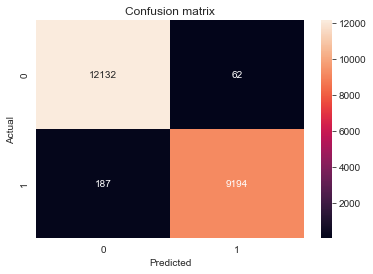

________________________________________________________________________________
              precision    recall  f1-score   support

         0.0       0.98      0.99      0.99     12194
         1.0       0.99      0.98      0.99      9381

    accuracy                           0.99     21575
   macro avg       0.99      0.99      0.99     21575
weighted avg       0.99      0.99      0.99     21575

Information:
Precision: Percentage of correct positive predictions relative to total positive predictions
Recall: Percentage of correct positive predictions relative to total actual positives.
F1 Score: A weighted harmonic mean of precision and recall. The closer to 1, the better the model.
________________________________________________________________________________


In [39]:
# Plot Confusion matrics
cm = confusion_matrix(y_true=y_train, y_pred=y_pred)
sns.heatmap(cm, annot=True, fmt='d')
plt.title("Confusion matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Plot classification report
print(80 * "_")
print(classification_report(y_true=y_train, y_pred=y_pred))
print("Information:")
print("Precision: Percentage of correct positive predictions relative to total positive predictions")
print("Recall: Percentage of correct positive predictions relative to total actual positives.")
print("F1 Score: A weighted harmonic mean of precision and recall. The closer to 1, the better the model.")
print(80 * "_")

---
# Task 4: Compare different classification models

Comparing
* logistic regression,
* classification tree,
* random forest,
* bagging,
* support vector machine (with two kernel functions),
* and neural network
for default prediction based on the out-of-sample performance measures (at least three different measures).

In [40]:
%%time
models = []

models.append(("LogisticRegression",LogisticRegression(fit_intercept=True, max_iter=5000, solver="saga")))
models.append(("DecisionTree",DecisionTreeClassifier()))
models.append(("RandomForest",RandomForestClassifier()))
models.append(("BaggingCLF",BaggingClassifier()))
models.append(("SVC",SVC(kernel='rbf')))
models.append(("SVC",SVC(kernel="linear")))
models.append(("NeuronalNetwork", MLPClassifier(alpha=1, max_iter=1000)))

results = []
names = []
for name,model in tqdm(models):
    result = cross_val_score(model, X_train_scaled, y_train,  cv=2)
    names.append(name)
    results.append(result)

for i in range(len(names)):
    print(names[i],results[i].mean())

100%|██████████| 7/7 [00:48<00:00,  6.90s/it]

LogisticRegression 0.9853071306357963
DecisionTree 0.9833603772087407
RandomForest 0.9918424273659993
BaggingCLF 0.9894785953539497
SVC 0.9799769023253694
SVC 0.9908227071552607
NeuronalNetwork 0.9818772478057003
CPU times: user 52.5 s, sys: 1.96 s, total: 54.4 s
Wall time: 48.5 s


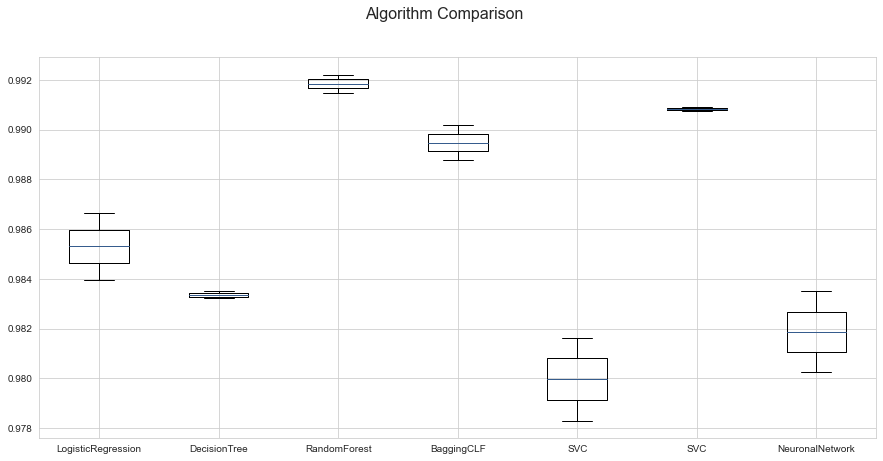

In [41]:
#results_df = pd.DataFrame({"Algorithm": names, "Score": results})

# boxplot algorithm comparison
fig = plt.figure(figsize=(15,7))
fig.suptitle('Algorithm Comparison', size=16)
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()